# DATASET :D  read, seed, urm 

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm 
import seaborn as sns
import math
import random

In [2]:
train = pd.read_csv("original/train_interactions.csv", sep='\t')

In [3]:
np.random.seed(0)

In [4]:
# collect data to build urm
playlists = train['pid'].values
tracks = train['tid'].values

n_tracks = 2262292
n_interactions = tracks.size


In [5]:
urm = sp.csr_matrix((np.ones(n_interactions), (playlists,tracks)), shape=(1000000, n_tracks),
                    dtype=np.int32)

In [6]:
#riepilogo 
def riepilogo(df):
    df_copy = df.copy() 
    
    df_copy['quantity'] = np.zeros(len(df_copy))
    df_copy['quantity'] = df_copy.groupby(df_copy['pid']).transform('count')
    
    print("numero di tracks>\t", len(np.unique(df_copy.tid.values)))
    print("numero di playlist\t", len(np.unique(df_copy.pid.values)))
    print("lunghezza media>\t", len(df)/len(np.unique(df_copy.pid.values)))
    print("max songs> \t\t", max(np.unique(df_copy.quantity.values)))
    print("num inter> \t\t", len(df_copy))
    valori = df_copy.groupby('pid').count()['quantity'].values
    sns.distplot(valori, bins=np.arange(min(valori),max(valori)))

# costanti

In [7]:
prime_n_tracks = 28000
prime_n_playlists = 75000
max_playlist_lenght = 100 
num_interactions_cut = 2

# TAGLIO TRAIN alle prime 21k canzoni.  e 90k pl.   tolgo le>100songs 

In [8]:
num_tracks = np.diff(urm.indptr)
mask_cut = np.where(num_tracks<=max_playlist_lenght )[0]
print(len(mask_cut),mask_cut)

788387 [     0      1      2 ... 999995 999997 999998]


In [9]:
train_cut = train[train.pid.isin(mask_cut)]
train_cut = train_cut[(train_cut.tid < prime_n_tracks)]
train_cut = train_cut[(train_cut.pid < prime_n_playlists)]
train_cut = train_cut.reset_index(drop=True)

# qui ho 18kk interactions, 20k songs, pl sotto i 100

###  taglio via i duplicati ora che posso fare una groupby in tempi umani 

In [10]:
train_finale = train_cut.groupby(['pid','tid'], as_index=False )['pos'].min()
train_finale = train_finale.reset_index(drop=True)

# qualche stat e tolgo le playlist sotto le 5 interazioni


numero di tracks>	 25824
numero di playlist	 51836
lunghezza media>	 28.385658615633922
max songs> 		 100
num inter> 		 1471399


/Users/lele/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


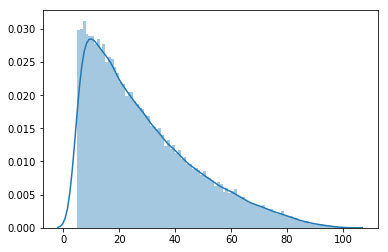

In [11]:
train_finale['quantity'] = np.zeros(len(train_finale))
train_finale['quantity'] = train_finale.groupby(train_finale['pid']).transform('count')
train_finale = train_finale[train_finale.quantity>=5]
riepilogo(train_finale)

In [12]:
train_finale.head()

,pid,tid,pos,quantity
0,0,0,0,51
1,0,1,1,51
2,0,2,2,51
3,0,3,3,51
4,0,4,4,51


# taglio canzoni con  meno di 3 interazioni

In [13]:
interazioni = train_finale.groupby('tid').count().values[:, [0]].ravel()
print(len(interazioni), interazioni)
mask_cut_interazioni = np.where(interazioni>=num_interactions_cut )[0]
print(len(mask_cut_interazioni),mask_cut_interazioni)

25824 [245 521 697 ... 102 145  55]
22476 [    0     1     2 ... 25821 25822 25823]


In [14]:
train_finale = train_finale[train_finale.tid.isin(mask_cut_interazioni)]
train_finale.drop('quantity', axis=1, inplace=True)
train_finale['quantity'] = np.zeros(len(train_finale))
train_finale['quantity'] = train_finale.groupby(train_finale['pid']).transform('count')
train_finale = train_finale[train_finale.quantity>=5]

# riepilogo

numero di tracks>	 20762
numero di playlist	 50446
lunghezza media>	 25.27363913888118
max songs> 		 100
num inter> 		 1274954


/Users/lele/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


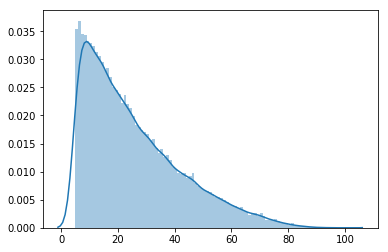

In [15]:
riepilogo(train_finale)

# scelgole target pl 

In [16]:
playlist_con_almeno_10 =  train_finale[(train_finale.quantity>=10)]

In [17]:
test_pl = np.sort(np.random.choice(np.unique(playlist_con_almeno_10.pid.values), 10000,replace=False))
prime_5k_pl = test_pl[:5000]
prime_5k_pl

array([    7,    23,    25, ..., 37517, 37519, 37527])

In [18]:
seconde_5k_pl = test_pl[5000:10000]
seconde_5k_pl

array([37540, 37552, 37554, ..., 74985, 74995, 74996])

In [19]:

len( prime_5k_pl)+len( seconde_5k_pl)

10000

# init

In [20]:
TRAIN_DATASET =  pd.DataFrame({'pid' : [] , 'tid':[]})
TEST_DATASET =  pd.DataFrame({'pid' : [] , 'tid':[]})

In [21]:
print(len(train_finale))
train_finale.head()

1274954


,pid,tid,pos,quantity
0,0,0,0,51
1,0,1,1,51
2,0,2,2,51
3,0,3,3,51
4,0,4,4,51


In [22]:
TRAIN_DATASET =  pd.DataFrame({'pid' : [] , 'tid':[]}, dtype=np.int32)
TEST_DATASET =  pd.DataFrame({'pid' : [] , 'tid':[]}, dtype=np.int32)

df_test = 0 
df_train = 0
df = 0 

set_tracce_tolte = set()
set_tracce_riman = set()
count_tolte = 0 
tolte_display = list()
rimanenti_display = list() 


# taglio 20% delle prime 5k, solo ultime track 


# train

In [23]:
for pl in tqdm(np.unique(train_finale.pid.values)):
    
    df = train_finale[train_finale.pid == pl ]
    
    if pl in prime_5k_pl:
        pass
    elif pl in seconde_5k_pl:
        pass
    else:
        df = df.sample(frac=1).reset_index(drop=True)
        TRAIN_DATASET = TRAIN_DATASET.append( df[['pid','tid']])

100%|██████████| 50446/50446 [07:46<00:00, 108.14it/s]


# prime, sequenziali 

In [24]:
for pl in tqdm(prime_5k_pl):
    
    df = train_finale[train_finale.pid == pl ]
    
    df = df.sort_values(['pos'])
    da_togliere = int(round(len(df)*0.2)) + random.randint(0, 1)

    da_tenere = len(df)-da_togliere

    df_train = df[:-da_togliere]
    df_test = df[da_tenere:]

    TRAIN_DATASET = TRAIN_DATASET.append( df_train[['pid','tid']])
    TEST_DATASET = TEST_DATASET.append( df_test[['pid','tid']]) 

100%|██████████| 5000/5000 [01:51<00:00, 44.98it/s]


# seconde, random

In [25]:

for pl in tqdm(seconde_5k_pl):
        
    
    df = train_finale[train_finale.pid == pl ]
    
    da_togliere = int(round(len(df)*0.2)) + random.randint(0, 1)

    da_tenere = len(df)-da_togliere

    canzoni = TRAIN_DATASET.tid.values
        
    prog = 0 
    while True:

        df = df.sample(frac=1).reset_index(drop=True)
        da_togliere = math.ceil(len(df)*0.2)

        df_train = df[:-da_togliere]
        df_test = df[da_tenere:]

        tolta_da_non_togliere = False
        
        for tid_to_check in df_test.tid.values:
            if tid_to_check not in canzoni:
                tolta_da_non_togliere=True
                
        if not tolta_da_non_togliere:
            break
            
        if prog ==10:
            print('prog')
            break
        prog+=1
        
    
    TRAIN_DATASET = TRAIN_DATASET.append( df_train[['pid','tid']])
    TEST_DATASET = TEST_DATASET.append( df_test[['pid','tid']]) 


 11%|█         | 560/5000 [00:15<02:10, 33.94it/s]

prog


 64%|██████▎   | 3179/5000 [01:34<00:54, 33.55it/s]

prog


100%|██████████| 5000/5000 [02:32<00:00, 32.75it/s]


In [26]:
print( len(TRAIN_DATASET),  len(TEST_DATASET),  len(TRAIN_DATASET)+len(TEST_DATASET))
print(len(train_finale))

1211791 63600 1275391
1274954


In [27]:
print( len(TRAIN_DATASET),  len(TEST_DATASET),  len(TRAIN_DATASET)+len(TEST_DATASET))
print(len(train_finale))
print(len(np.unique(TRAIN_DATASET.pid.values)))
print(len(np.unique(TEST_DATASET.pid.values)))

1211791 63600 1275391
1274954
50446
10000


# check 

In [28]:
len(np.unique(train_finale.pid.values))

50446

In [29]:
import gc
gc.collect()
del(train,playlists )
del(train_cut)
del(urm)
gc.collect()

14

In [30]:
len(np.unique(train_finale.tid.values))

20762

In [31]:
len(np.unique(TRAIN_DATASET.pid.values))

50446

In [32]:
len( np.unique(TEST_DATASET.pid.values) )

10000

# controlli pre scrittura file

In [33]:
TRAIN_DATASET.reset_index(inplace=True, drop=True)
TRAIN_DATASET

,pid,tid
0,0,45
1,0,5
2,0,50
3,0,8
4,0,31
5,0,41
6,0,1
7,0,27
8,0,17
9,0,3


In [34]:
TEST_DATASET.reset_index(inplace=True, drop=True)
TEST_DATASET

,pid,tid
0,7,426
1,7,427
2,7,428
3,7,429
4,7,430
5,7,431
6,7,432
7,7,433
8,7,434
9,7,435


# SHUFFLE 

### shuffle playlist

In [35]:
playlists_ids = np.sort(np.unique(TRAIN_DATASET.pid.values))
my_range_p = np.arange(len(playlists_ids))
np.random.shuffle(my_range_p)

print(len(playlists_ids), len(my_range_p))
dict_playlists = dict(zip(playlists_ids,  my_range_p))
# dict_playlists

50446 50446


In [36]:
tracks_ids = np.sort(np.unique(TRAIN_DATASET.tid.values))
my_range_t = np.arange(len(tracks_ids))
np.random.shuffle(my_range_t)

print(len(tracks_ids), len(my_range_t))
dict_tracks = dict(zip(tracks_ids,  my_range_t))
# dict_tracks

20635 20635


# dict fatti>   dict_playlists dict_tracks

In [37]:
TRAIN_DATASET['new_tid'] = TRAIN_DATASET['tid'].map(dict_tracks)
TRAIN_DATASET['new_pid'] = TRAIN_DATASET['pid'].map(dict_playlists)
TRAIN_DATASET

,pid,tid,new_tid,new_pid
0,0,45,1126,28812
1,0,5,8749,28812
2,0,50,2778,28812
3,0,8,19733,28812
4,0,31,12708,28812
5,0,41,14172,28812
6,0,1,16451,28812
7,0,27,20028,28812
8,0,17,3434,28812
9,0,3,9412,28812


In [38]:
TRAIN_DATASET[TRAIN_DATASET.isnull().any(axis=1)]

,pid,tid,new_tid,new_pid


In [39]:
TEST_DATASET['new_tid'] = TEST_DATASET['tid'].map(dict_tracks)
TEST_DATASET['new_pid'] = TEST_DATASET['pid'].map(dict_playlists)
TEST_DATASET

,pid,tid,new_tid,new_pid
0,7,426,20455.0,8363
1,7,427,NaN,8363
2,7,428,4720.0,8363
3,7,429,NaN,8363
4,7,430,8423.0,8363
5,7,431,5988.0,8363
6,7,432,15284.0,8363
7,7,433,12409.0,8363
8,7,434,16442.0,8363
9,7,435,7485.0,8363


In [40]:
TEST_DATASET[TEST_DATASET.isnull().any(axis=1)]

,pid,tid,new_tid,new_pid
1,7,427,NaN,8363
3,7,429,NaN,8363
10,7,436,NaN,8363
64,66,3450,NaN,46935
67,66,3453,NaN,46935
71,66,3457,NaN,46935
73,66,3460,NaN,46935
93,83,4189,NaN,4528
102,84,4217,NaN,34933
149,93,4640,NaN,24429


In [41]:
TEST_DATASET.dropna(inplace=True)

In [42]:
TEST_DATASET[TEST_DATASET.isnull().any(axis=1)]

,pid,tid,new_tid,new_pid


# SCRITTURA DI TRAIN

In [43]:
recsys18_train = TRAIN_DATASET.copy()

In [44]:
recsys18_train.drop(['pid','tid'], axis=1, inplace=True)
recsys18_train.rename(index=str, columns={"new_pid": "playlist_id", "new_tid": "track_id"}, inplace=True)
recsys18_train

,track_id,playlist_id
0,1126,28812
1,8749,28812
2,2778,28812
3,19733,28812
4,12708,28812
5,14172,28812
6,16451,28812
7,20028,28812
8,3434,28812
9,9412,28812


In [45]:
recsys18_train.sort_values(['playlist_id'],inplace=True)
recsys18_train = recsys18_train.reset_index(drop=True)
recsys18_train = recsys18_train[['playlist_id','track_id']]
recsys18_train

,playlist_id,track_id
0,0,14301
1,0,8360
2,0,12844
3,0,18397
4,0,1220
5,1,18466
6,1,16782
7,1,7545
8,1,8248
9,1,16866


In [46]:
recsys18_train.to_csv("recsys18_train.csv", sep=',',index=False)

# SCRITTURA DI TEST 

In [47]:
recsys18_test = TEST_DATASET.copy()
recsys18_test.drop(['pid','tid'], axis=1, inplace=True)
recsys18_test.rename(index=str, columns={"new_pid": "playlist_id", "new_tid": "track_id"}, inplace=True)


In [178]:
recsys18_test.sort_values(['playlist_id'],inplace=True)
recsys18_test = recsys18_test.reset_index(drop=True)
recsys18_test = recsys18_test[['playlist_id','track_id']]
recsys18_test.track_id = recsys18_test.track_id.astype(np.int32)
recsys18_test.head()

,playlist_id,track_id
0,3,19834
1,3,1111
2,3,11595
3,3,8426
4,6,1111


In [179]:
recsys18_test.to_csv("recsys18_test_per_noi.csv", sep=',',index=False)

In [196]:
test_series = recsys18_test.groupby('playlist_id')['track_id'].apply(list)
test_indices = test_series.index
test_values = test_series.values

In [199]:
file = open("recsys18_solution.csv","w") 
file.write("playlist_id, track_ids\n")
for i, target_pl_tmp in enumerate(test_indices):
    file.write(str(target_pl_tmp)+",")
    for num_to_write in test_values[i]:
        file.write(str(num_to_write)+" ")
    file.write("\n")
file.close() 

# WRITE SAMPLE SUBMISSION 

In [201]:
file = open("recsys18_sample_submission.csv","w") 
file.write("playlist_id, track_ids\n")
for i, target_pl_tmp in enumerate(test_indices):
    file.write(str(target_pl_tmp)+",")
    for j in range(0,9):
        file.write(str(j)+" ")
    file.write(str(j+1))
    file.write("\n")
file.close() 

# scrittura di target 

In [49]:
target_sequenziali = np.sort(np.array([dict_playlists[x] for x in prime_5k_pl]))
print(len(target_sequenziali),np.sort( np.array(target_sequenziali)))

5000 [    7    25    29 ... 50420 50428 50431]


In [50]:
target_rng = np.sort(np.array([dict_playlists[x] for x in seconde_5k_pl]))
print(len(target_rng), np.sort(np.array(target_rng)))

5000 [    3     6    17 ... 50416 50417 50424]


In [51]:
target_playlists = pd.DataFrame({'target_playlist' : [] })
target_playlists['target_playlist']  = np.concatenate([target_sequenziali,target_rng])
target_playlists.to_csv("recsys18_target_playlists.csv", sep=',',index=False)

# TRACKS.csv

In [58]:
tracks = pd.read_csv("original/tracks.csv", sep='\t')

In [60]:
tracks[tracks.tid.isin(TRAIN_DATASET.tid)]

,tid,arid,alid,track_uri,track_name,duration_ms
0,0,0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),226863
1,1,1,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,198800
2,2,2,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,235933
3,3,3,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,267266
4,4,4,4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,227600
5,5,5,5,spotify:track:0XUfyU2QviPAs6bxSpXYG4,Yeah!,250373
6,6,5,6,spotify:track:68vgtRHr7iZHpzGpon6Jlo,My Boo,223440
7,7,6,7,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,Buttons,225560
8,8,7,8,spotify:track:7H6ev70Weq6DdpZyyTmUXk,Say My Name,271333
9,9,8,9,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,Hey Ya! - Radio Mix / Club Mix,235213


In [61]:
tracks = tracks[tracks.tid.isin(TRAIN_DATASET.tid)]
tracks['track_id'] = tracks['tid'].map(dict_tracks)

/Users/lele/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,tid,arid,alid,track_uri,track_name,duration_ms,track_id
0,0,0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),226863,14807
1,1,1,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,198800,16451
2,2,2,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,235933,956
3,3,3,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,267266,9412
4,4,4,4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,227600,2765
5,5,5,5,spotify:track:0XUfyU2QviPAs6bxSpXYG4,Yeah!,250373,8749
6,6,5,6,spotify:track:68vgtRHr7iZHpzGpon6Jlo,My Boo,223440,3880
7,7,6,7,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,Buttons,225560,8324
8,8,7,8,spotify:track:7H6ev70Weq6DdpZyyTmUXk,Say My Name,271333,19733
9,9,8,9,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,Hey Ya! - Radio Mix / Club Mix,235213,9963


In [109]:
def apply_random_perc_and_cut(x):
    x = x + x*random.choice(list(range(-20,0))+list(range(1,21)))*0.01
    x = x/1000
    return  int(round(x))

tracks['duration_sec'] = tracks['duration_ms'].apply(lambda x: apply_random_perc_and_cut(x))
tracks

/Users/lele/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,tid,arid,alid,track_uri,track_name,duration_ms,track_id,duration_sec
0,0,0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),226863,14807,229
1,1,1,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,198800,16451,187
2,2,2,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,235933,956,226
3,3,3,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,267266,9412,321
4,4,4,4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,227600,2765,250
5,5,5,5,spotify:track:0XUfyU2QviPAs6bxSpXYG4,Yeah!,250373,8749,248
6,6,5,6,spotify:track:68vgtRHr7iZHpzGpon6Jlo,My Boo,223440,3880,212
7,7,6,7,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,Buttons,225560,8324,246
8,8,7,8,spotify:track:7H6ev70Weq6DdpZyyTmUXk,Say My Name,271333,19733,255
9,9,8,9,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,Hey Ya! - Radio Mix / Club Mix,235213,9963,212


### albums e artisti da dentro tracks 

In [110]:
album_ids = np.sort(np.unique(tracks.alid.values))
artist_ids = np.sort(np.unique(tracks.arid.values))

my_range_album = np.arange(len(album_ids))
my_range_artist = np.arange(len(artist_ids))

np.random.shuffle(my_range_album)
np.random.shuffle(my_range_artist)


print("albums:",len(album_ids), len(my_range_album))
print("artist:",len(artist_ids), len(my_range_artist))

dict_albums = dict(zip(album_ids,  my_range_album))
dict_artist = dict(zip(artist_ids,  my_range_artist))

albums: 12744 12744
artist: 6668 6668


In [111]:
tracks['album_id'] = tracks['alid'].map(dict_albums)
tracks['artist_id'] = tracks['arid'].map(dict_artist)

/Users/lele/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/lele/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [139]:
recsys18_tracks = tracks[['track_id','album_id','artist_id','duration_sec']]
recsys18_tracks =  recsys18_tracks.sort_values('track_id')
recsys18_tracks.reset_index(drop=True,inplace=True)
recsys18_tracks.to_csv("recsys18_tracks.csv", sep=',',index=False)


# PLAYLISTS.csv

In [145]:
playlists = pd.read_csv("original/train_playlists.csv", sep='\t')

In [146]:
playlists = playlists[playlists.pid.isin(TRAIN_DATASET.pid.values)]  

In [147]:
playlists['playlist_id'] = playlists['pid'].map(dict_playlists)

In [175]:
recsys18_playlists = playlists[['playlist_id','num_edits','num_followers']]
recsys18_playlists =  recsys18_playlists.sort_values('playlist_id')
recsys18_playlists.reset_index(drop=True,inplace=True)
recsys18_playlists.head()

,playlist_id,num_edits,num_followers
0,0,19,1
1,1,2,1
2,2,5,2
3,3,7,1
4,4,27,1


In [162]:
recsys18_playlists.to_csv("recsys18_playlists.csv", sep=',',index=False)

# ALBUMS.csv 

In [159]:
albums = pd.read_csv("original/albums.csv", sep='\t')

In [174]:
albums = albums[albums.alid.isin(tracks.alid.values)]  
albums['album_id'] = albums['alid'].map(dict_albums)
albums.head()

,alid,album_uri,album_name,album_id
0,0,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,The Cookbook,1175
1,1,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,In The Zone,3001
2,2,spotify:album:25hVFAxTlDvXbx2X2QkUkE,Dangerously In Love (Alben für die Ewigkeit),3390
3,3,spotify:album:6QPkyl04rXwTGlGlcYaRoW,Justified,8140
4,4,spotify:album:6NmFmPX56pcLBOFMhIiKvF,Hot Shot,4701


In [173]:
recsys18_albums = albums[['album_id']]
recsys18_albums = recsys18_albums.sort_values('album_id')
recsys18_albums.reset_index(drop=True,inplace=True)
recsys18_albums.head()

,album_id
0,0
1,1
2,2
3,3
4,4


In [163]:
recsys18_albums.to_csv("recsys18_albums.csv", sep=',',index=False)

# ARTIST.csv

In [172]:
artists = pd.read_csv("original/artists.csv", sep='\t')
artists = artists[artists.arid.isin(tracks.arid.values)] 
artists['artist_id'] = artists['arid'].map(dict_artist)

recsys18_artists = artists[['artist_id']]
recsys18_artists = recsys18_artists.sort_values('artist_id')
recsys18_artists.reset_index(drop=True,inplace=True)
recsys18_artists.head()

,artist_id
0,0
1,1
2,2
3,3
4,4


In [171]:
recsys18_artists.to_csv("recsys18_artists.csv", sep=',',index=False)

# DICTS 

In [204]:
import json
def json_write(name, data):
    with open(name+'.json', 'w') as fp:
        json.dump(data, fp)
        
def json_read(name):
    with open(name+'.json', 'r') as fp:
        data = json.load(fp)
    return data 

In [ ]:
json_write("recsys18_dict_albums",dict_albums)
json_write("recsys18_dict_artist",dict_artist)
json_write("recsys18_dict_playlists",dict_playlists)
json_write("recsys18_dict_tracks",dict_tracks)

dict_albums
dict_artist
dict_playlists
dict_tracks